In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim#Optimizers
from torchvision import transforms, models#Different models in PyTorch

In [ ]:
vgg19 = models.vgg19(pretrained=True).features#getting only conv and pool layers, for FC layers use .classifier
for param in vgg19.parameters():
    param.requires_grad = False#freezing parameters

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# image size should be less than 400 pixels in height
def load_image(img_path,size=(400,600)):
  image = Image.open(img_path).convert('RGB')#loading and converting to RGB
  image_transform = transforms.Compose(
      [
          transforms.Resize(size),#resizing to 400x500
          transforms.ToTensor(),#Converting to tensor
          transforms.Normalize((0.485, 0.456, 0.406), #Mean for each channel
                              (0.229, 0.224, 0.225))  #STD for each channel
      ]
  )
  image=image_transform(image)[:3,:,:]#removing alpha channel i.e restricting to RGB
  image=image.unsqueeze(0)#Returns a new tensor with a dimension of size one inserted at the specified position. Adding the 'm' parameter
  print(image.shape)
  return image

In [ ]:
content=load_image('paris.jpg').to(device)
style=load_image('vangough.jpg').to(device)
target = content.clone().requires_grad_(True).to(device)#enabling gradient descent on it

torch.Size([1, 3, 400, 600])
torch.Size([1, 3, 400, 600])


In [ ]:
#converting to numpy array to display it
def to_numpy(image_tensor):
  image = image_tensor.to('cpu').clone().detach()#creates a new tensor called image and detaches it from computational graph
  image = image.numpy().squeeze()#removes 'm' parameter
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))#de-normalizing image
  image = image.clip(0, 1)#restrict all values between 0 and 1
  return image

In [ ]:
def display(image1,image2):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
  ax1.imshow(to_numpy(image1))
  ax2.imshow(to_numpy(image2))

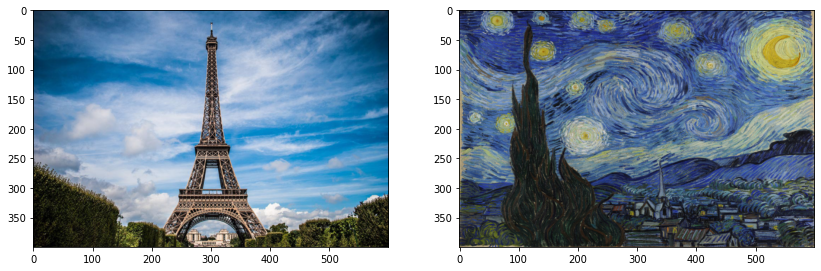

In [ ]:
display(content,style)

In [ ]:
def features(image,layer_dict):
  temp=image#temp variable to store image tensor
  weights={}#dictionary to store weigths in layer_number:weight format
  for number, name in vgg19._modules.items():#looping through all layers
    temp=name(temp)#forward prop through each layer soo that layer for which we need the weights for gets tensor in correct shape
    if number in layer_dict:
      weights[layer_dict[number]]=temp
  return weights    

In [ ]:
def gram(weights):
  m,channel,h,w=weights.size()
  weights=weights.view(channel,h*w)#unrolling in channel_first format
  gram=torch.mm(weights, weights.t())#gram matrix=tensor*tensor transpose
  return gram

In [ ]:
style_weights = {'conv1_1': 0.4,
                 'conv2_1': 0.3,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.9}

In [ ]:
def optimize(lr,alpha,beta,iterations):
  content_features=features(content,{'21': 'conv4_2'})#extracting content features
  
  style_features=features(style,
          {'0': 'conv1_1',
          '5': 'conv2_1', 
          '10': 'conv3_1', 
          '19': 'conv4_1',  
          '28': 'conv5_1'})#extracting style features
  
  style_grams={layer: gram(style_features[layer]) for layer in style_features}#style features to style grams
  
  optimizer = optim.Adam([target], lr)#adam optimizer is used

  for i in range(iterations+1):
    target_features=features(target,{
          '21': 'conv4_2',
          '0': 'conv1_1',
          '5': 'conv2_1', 
          '10': 'conv3_1', 
          '19': 'conv4_1',  
          '28': 'conv5_1'})#extracting target features
    
    content_loss=torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss=0
    for layer in style_weights:
      target_feature=target_features[layer]#getting target feature for a layer
      _, d, h, w = target_feature.shape
      target_gram=gram(target_feature)#target feature to target gram
      style_gram=style_grams[layer]#getting style gram for a layer
      layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
      style_loss += layer_style_loss / (d * h * w)

    total_loss=alpha*content_loss + beta*style_loss
    optimizer.zero_grad()#initializing all weights to zero as .backward does addition accumulation 
    total_loss.backward()#accumulates the gradient (by addition) for each parameter
    optimizer.step()#performs a parameter update based on the current gradient 

    if(i%500==0):
      print(i,total_loss)
      plt.imshow(to_numpy(target))    
      plt.show()
  
  return target

0 tensor(60205.4727, device='cuda:0', grad_fn=<AddBackward0>)


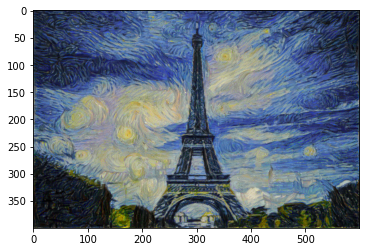

500 tensor(53529.7227, device='cuda:0', grad_fn=<AddBackward0>)


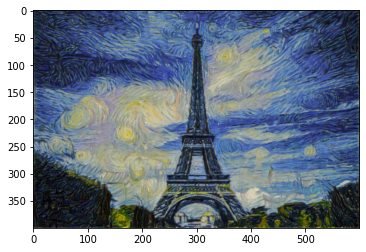

1000 tensor(51044.0625, device='cuda:0', grad_fn=<AddBackward0>)


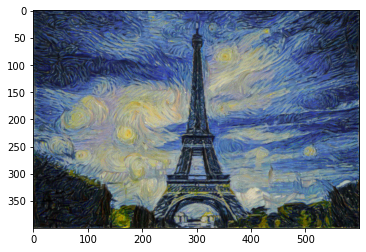

1500 tensor(48645.3398, device='cuda:0', grad_fn=<AddBackward0>)


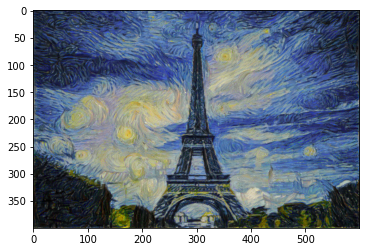

In [ ]:
target=optimize(lr=0.005,alpha=1,beta=1000000,iterations=1500)

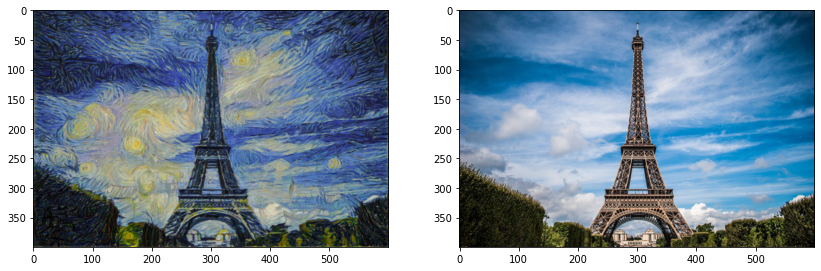

In [ ]:
display(target,content)